In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
data = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")

data.index = pd.to_datetime(data.index)

# Step 1: Filter for rows where QI == 0 and no NaN in any relevant column
data_filtered = data[(data['QI'] == 0) & (data['freq'].notna())].dropna()

# Recheck for NaN
print("NaN Summary after filtering for QI and freq in data_filtered:")
print(data_filtered.isna().sum())

# Step 2: Group the data by the hour
hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))

# Step 3: Filter out incomplete hours 
valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)

# Step 4: Extract the 'freq' column and add a 'Time' column
valid_hours['Time'] = valid_hours.index  #
freq = valid_hours['freq']

# Validate that valid_hours is a multiple of 3600
print(f"Total rows in valid_hours: {len(valid_hours)}")
print(f"Is valid_hours a multiple of 3600? {len(valid_hours) % 3600 == 0}")


# Delete QI column and convert frequency to omega and add 'omega' column
valid_hours.drop(columns=['QI'], inplace=True)
valid_hours['omega'] = 2 * np.pi * (valid_hours['freq'] - 60)

# Look the first 10 rows of valid_hours
print(valid_hours.head(10))
len(valid_hours)/3600


NaN Summary after filtering for QI and freq in data_filtered:
freq    0
QI      0
dtype: int64


C:\Users\wp7528\AppData\Local\Temp\ipykernel_18660\3601689702.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))


Total rows in valid_hours: 8823600
Is valid_hours a multiple of 3600? True
                          freq                Time     omega
2024-08-15 01:00:00  59.974473 2024-08-15 01:00:00 -0.160393
2024-08-15 01:00:01  59.975651 2024-08-15 01:00:01 -0.152990
2024-08-15 01:00:02  59.977579 2024-08-15 01:00:02 -0.140874
2024-08-15 01:00:03  59.976437 2024-08-15 01:00:03 -0.148052
2024-08-15 01:00:04  59.974978 2024-08-15 01:00:04 -0.157216
2024-08-15 01:00:05  59.973959 2024-08-15 01:00:05 -0.163623
2024-08-15 01:00:06  59.977355 2024-08-15 01:00:06 -0.142285
2024-08-15 01:00:07  59.976714 2024-08-15 01:00:07 -0.146311
2024-08-15 01:00:08  59.977276 2024-08-15 01:00:08 -0.142779
2024-08-15 01:00:09  59.978177 2024-08-15 01:00:09 -0.137119


2451.0

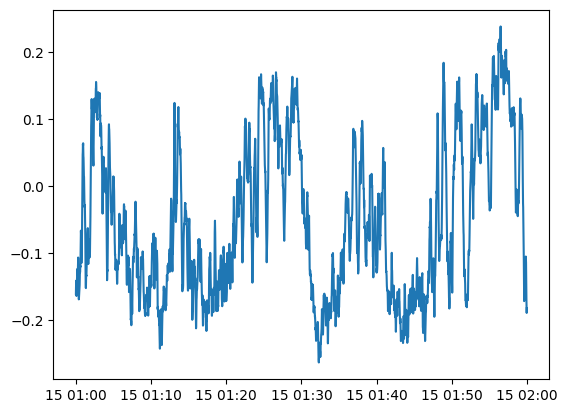

In [3]:
# Plot the omega data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])

In [6]:
def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data


In [4]:
from scipy.integrate import cumtrapz

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

(8823600, 16)


<Axes: xlabel='Time (samples)'>

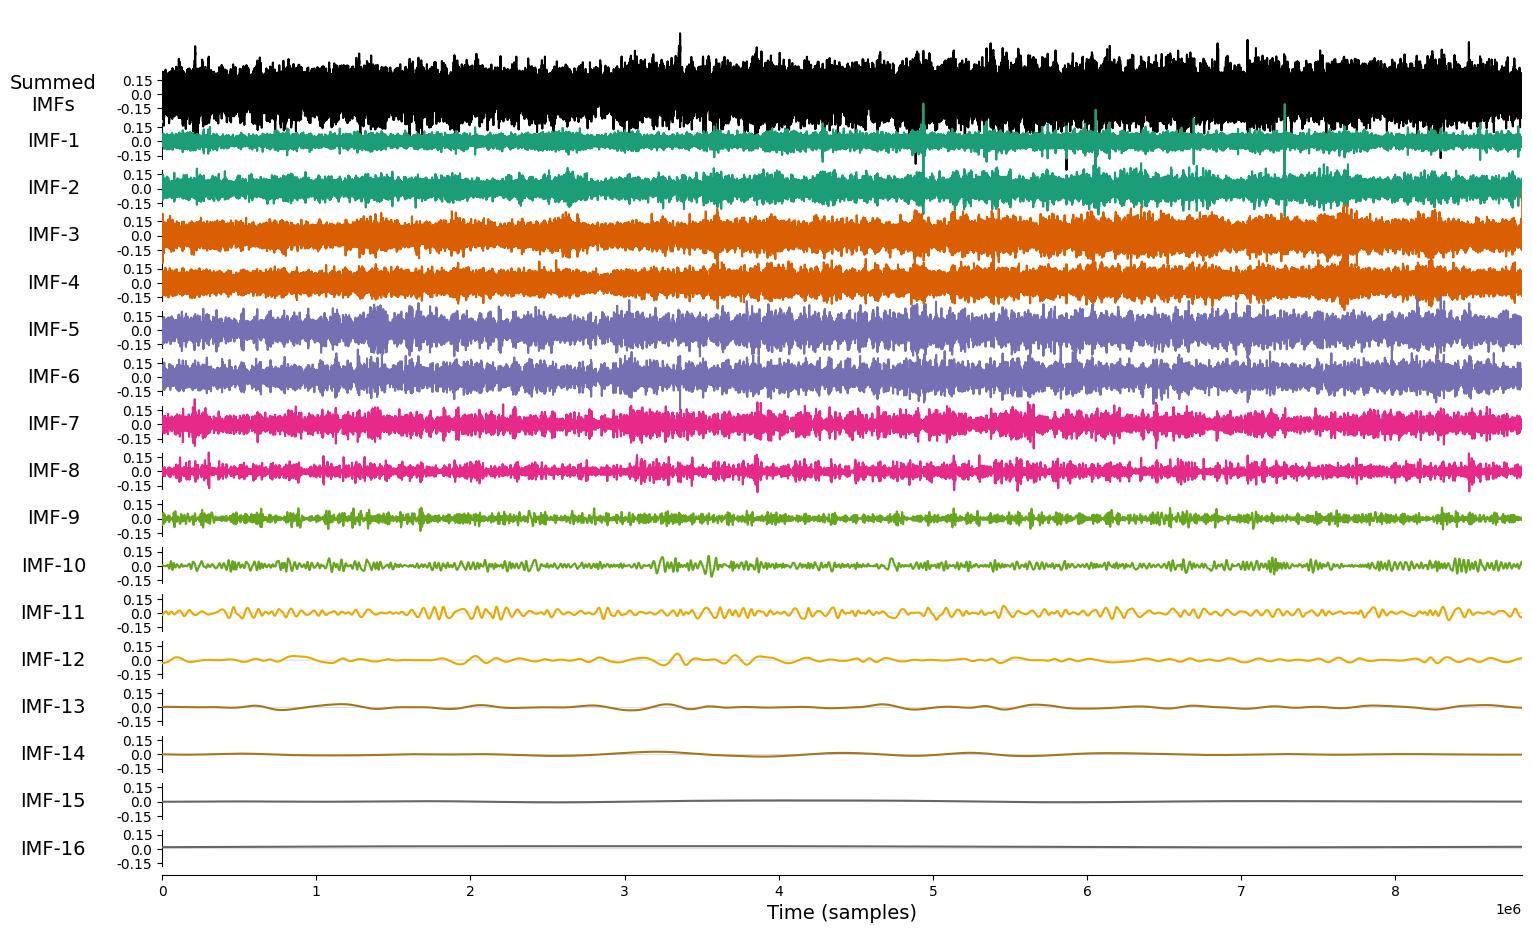

In [5]:
import emd

omega_data = valid_hours['omega'].values

# Apply EMD
imf = emd.sift.sift(omega_data)
print(imf.shape)

emd.plotting.plot_imfs(imf)


<Axes: xlabel='Time (samples)'>

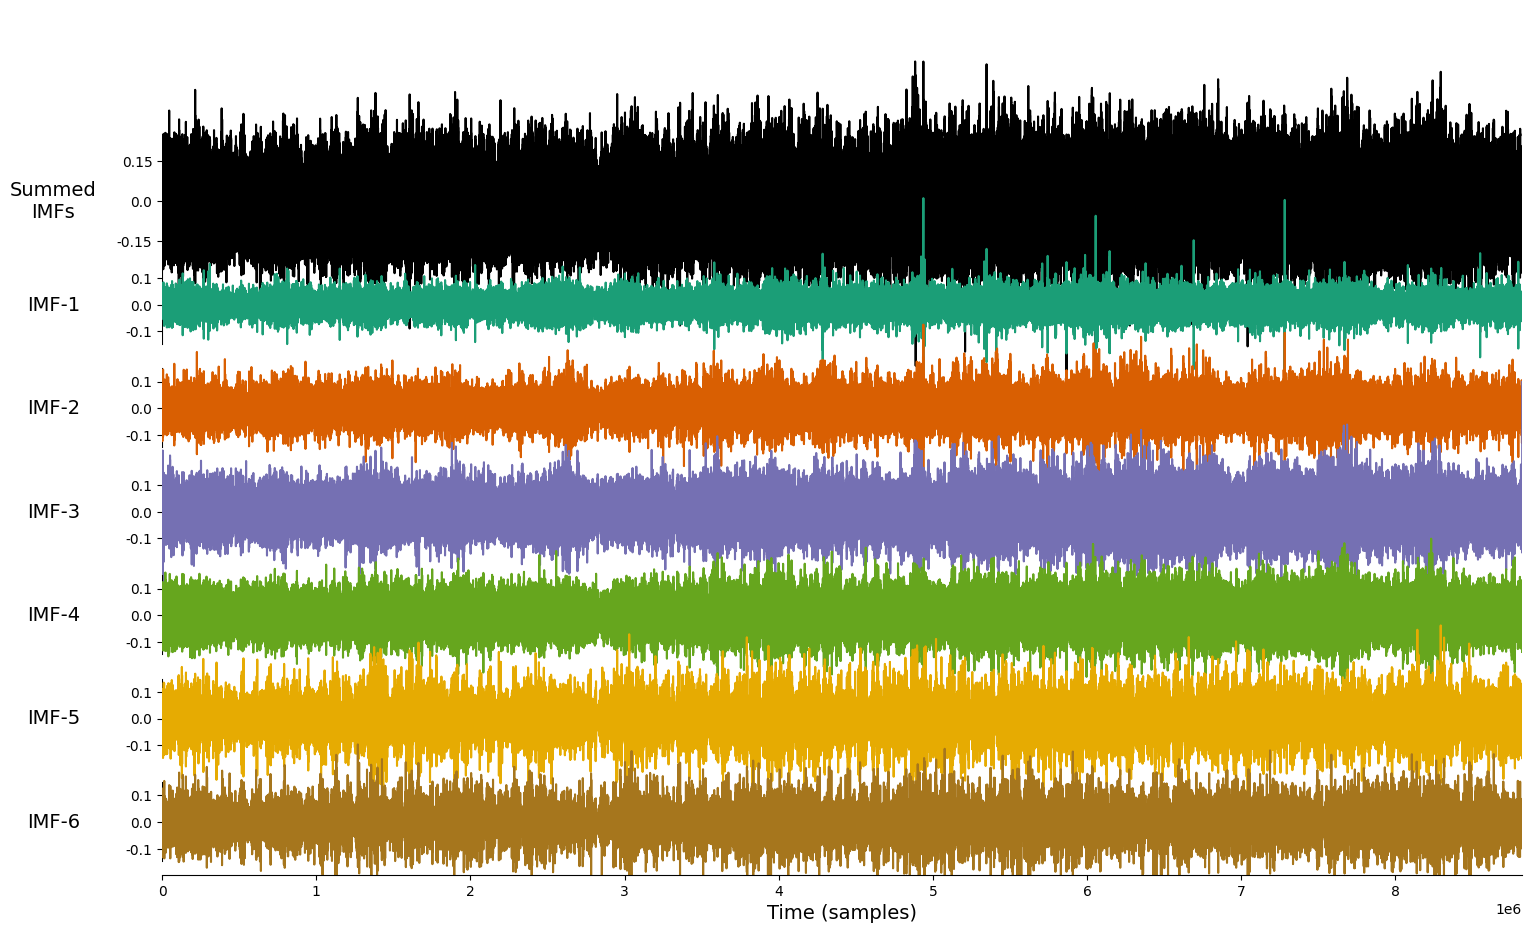

In [6]:

# Plot only the first 5 IMFs
emd.plotting.plot_imfs(imf[:, :6])



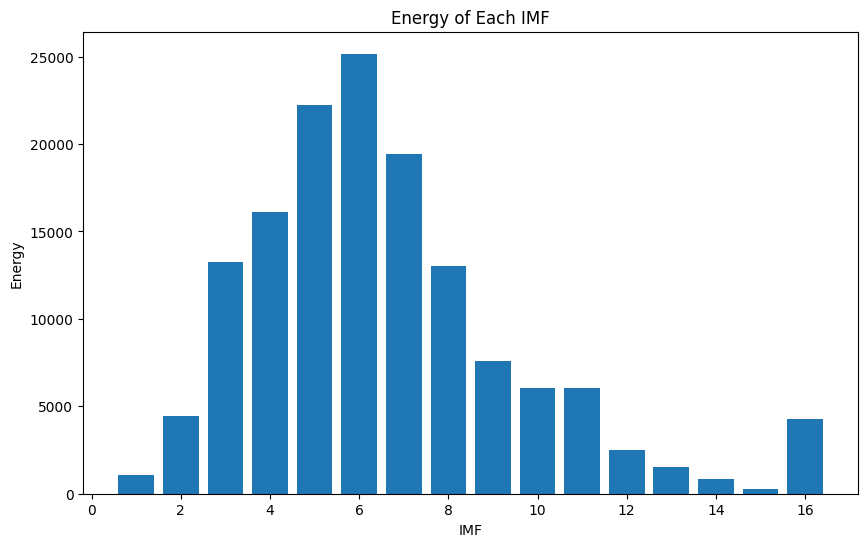

IMFs to keep (1-based index): [4, 5, 6, 7]
IMF with the highest energy: 6


In [7]:
# The energy of an IMF can be calculated as the sum of the squared values of the IMF.
# Typically, IMFs with very low energy can be discarded as they contribute little to the overall signal.

def calculate_energy(imf):
    return np.sum(imf**2)

# Calculate the energy of each IMF
imf_energies = [calculate_energy(imf[:, i]) for i in range(imf.shape[1])]

# Plot the energy of each IMF
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(imf_energies) + 1), imf_energies)
plt.xlabel('IMF')
plt.ylabel('Energy')
plt.title('Energy of Each IMF')
plt.show()

# Decide the number of IMFs to keep based on a threshold of the total energy
total_energy = np.sum(imf_energies)
energy_threshold = 0.10  # Keep IMFs with energy above 15% of the total energy
imfs_to_keep = [i for i, energy in enumerate(imf_energies) if energy / total_energy > energy_threshold]

# Convert to 1-based indexing for display purposes
imfs_to_keep_display = [i + 1 for i in imfs_to_keep]

# Check if the plot with the highest energy has the greatest percentage of energy
highest_energy_imf = np.argmax(imf_energies)
highest_energy_percentage = imf_energies[highest_energy_imf] / total_energy * 100
print(f"IMFs to keep (1-based index): {imfs_to_keep_display}")
print(f"IMF with the highest energy: {highest_energy_imf + 1}")




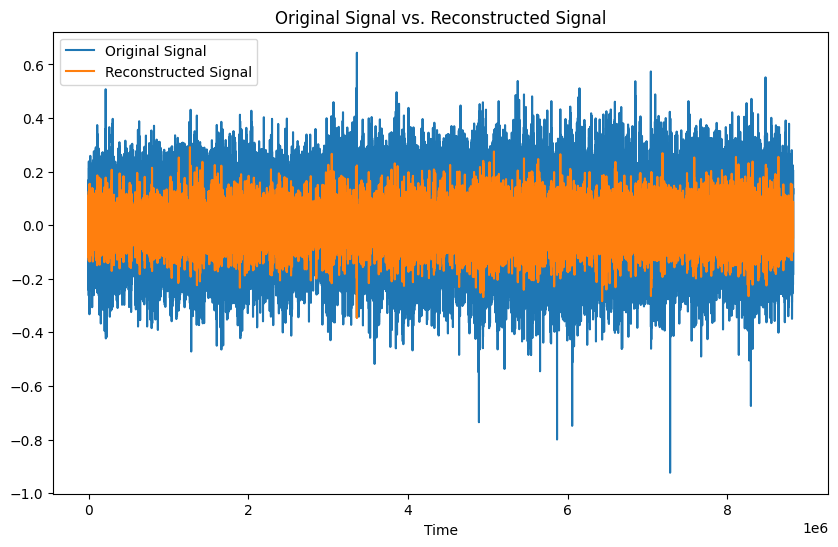

In [ ]:
# Sum the selected IMFs to reconstruct the signal
#reconstructed_signal = np.sum(imf[:, imfs_to_keep], axis=1)
reconstructed_signal = imf[:, 5] # imf6
# Plot the original signal and the reconstructed signal
plt.figure(figsize=(10, 6))
plt.plot(omega_data, label='Original Signal')
plt.plot(reconstructed_signal, label='Reconstructed Signal')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Original Signal vs. Reconstructed Signal')
plt.legend()

In [9]:
# add the reconstructed signal to the valid_hours dataframe and rename it to omega_filtered
valid_hours['omega_filtered'] = reconstructed_signal
valid_hours.head()


,freq,Time,omega,omega_filtered
2024-08-15 01:00:00,59.974473,2024-08-15 01:00:00,-0.160393,-0.118920
2024-08-15 01:00:01,59.975651,2024-08-15 01:00:01,-0.152990,-0.117805
2024-08-15 01:00:02,59.977579,2024-08-15 01:00:02,-0.140874,-0.116674
2024-08-15 01:00:03,59.976437,2024-08-15 01:00:03,-0.148052,-0.115527
2024-08-15 01:00:04,59.974978,2024-08-15 01:00:04,-0.157216,-0.114363


In [10]:
def split_into_chunks(data, region_name, chunk_size=3600):
    chunks = []
    num_chunks = len(data) // chunk_size
    
    for i in range(num_chunks):
        chunk = data.iloc[i*chunk_size:(i+1)*chunk_size].copy()
        chunk['Region'] = region_name
        chunks.append(chunk)
    
    return chunks

# Delete the 'Time' column from valid_hours
valid_hours.drop(columns=['Time'], inplace=True)

# Split the valid_hours dataframe into chunks
chunks = split_into_chunks(valid_hours, 'South Korea')


In [11]:
chunks

[                          freq     omega  omega_filtered       Region
 2024-08-15 01:00:00  59.974473 -0.160393       -0.118920  South Korea
 2024-08-15 01:00:01  59.975651 -0.152990       -0.117805  South Korea
 2024-08-15 01:00:02  59.977579 -0.140874       -0.116674  South Korea
 2024-08-15 01:00:03  59.976437 -0.148052       -0.115527  South Korea
 2024-08-15 01:00:04  59.974978 -0.157216       -0.114363  South Korea
 ...                        ...       ...             ...          ...
 2024-08-15 01:59:55  59.975626 -0.153148       -0.066381  South Korea
 2024-08-15 01:59:56  59.973152 -0.168694       -0.067114  South Korea
 2024-08-15 01:59:57  59.971792 -0.177234       -0.067842  South Korea
 2024-08-15 01:59:58  59.969941 -0.188864       -0.068566  South Korea
 2024-08-15 01:59:59  59.971077 -0.181731       -0.069284  South Korea
 
 [3600 rows x 4 columns],
                           freq     omega  omega_filtered       Region
 2024-08-15 02:00:00  59.972838 -0.170663       -

In [12]:
from sklearn.metrics import explained_variance_score, max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = {}
    scores = {}

    transformations = {
        "exp_1000": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
        #"exp_3600": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 3600) - 1).reshape(-1, 1),

        # Sine transformation of time
        "sin_time": lambda chunk: np.sin((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
        
        # Cosine transformation of time
        "cos_time": lambda chunk: np.cos((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),

        # Time itself
        "linear_time": lambda chunk: np.arange(0, len(chunk), 1).reshape(-1, 1),

        "cumsum_omega": lambda chunk: np.cumsum(np.abs(chunk['omega_filtered'].values)).reshape(-1, 1),
        "cumsum_theta": lambda chunk: np.cumsum(np.abs(integrate_data(chunk['omega_filtered'].values))).reshape(-1, 1),
        "diff_omega": lambda chunk: np.insert(np.diff(chunk['omega_filtered'].values), 0, 0).reshape(-1, 1),
        "diff_theta": lambda chunk: np.insert(np.diff(integrate_data(chunk['omega_filtered'].values)), 0, 0).reshape(-1, 1),

        
        "log_time": lambda chunk: np.log1p((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1),
        "squared_time": lambda chunk: ((chunk.index - chunk.index[0]).total_seconds().to_numpy() ** 2).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = []

        for chunk in region_data:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            
            # Apply the selected time transformation
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
            
            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)
            
            # Compute the explained variance score
            score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name].append(score)

        # Compute the mean score for this transformation
        mean_score = np.mean(scores[transform_name])
        print(f"Mean Model Score for {region_name} using {transform_name}: {mean_score}")

    return sindy_models, scores


In [13]:
sindy_models, scores = calculate_model_scores(chunks, 'South Korea', n=3)

Mean Model Score for South Korea using exp_1000: 0.9714379857726559
Mean Model Score for South Korea using sin_time: 0.5518907423958945
Mean Model Score for South Korea using cos_time: 0.5518926765459609
Mean Model Score for South Korea using linear_time: 0.6263297506584156
Mean Model Score for South Korea using cumsum_omega: 0.9629251443607997
Mean Model Score for South Korea using cumsum_theta: 0.9440061959434485
Mean Model Score for South Korea using diff_omega: 0.7906353584237632
Mean Model Score for South Korea using diff_theta: 0.9771430687416868
Mean Model Score for South Korea using log_time: 0.9583765830941058
Mean Model Score for South Korea using squared_time: 0.901746231859546


In [14]:
import numpy as np
import pysindy as ps
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error

def calculate_sindy_train_test(region_data, region_name, n=2, test_size=0.2):
    sindy_models = {}
    scores = {}

    # Split data into train and test sets
    train_chunks, test_chunks = train_test_split(region_data, test_size=test_size, shuffle=False)

    transformations = {
        "exp_1000": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = {"train": [], "test": []}

        # Train SINDy on training chunks
        for chunk in train_chunks:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)

            # Compute training score
            train_score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name]["train"].append(train_score)

        # Test the model on test chunks
        for chunk in test_chunks:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            t_test_chunk = transform_func(chunk)

            x_test_augmented_chunk = np.hstack([stacked_data_chunk, t_test_chunk])

            # Compute test score
            test_score = model_chunk.score(x_test_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name]["test"].append(test_score)

        # Compute mean scores
        mean_train_score = np.mean(scores[transform_name]["train"])
        mean_test_score = np.mean(scores[transform_name]["test"])
        print(f"Mean Train Score for {region_name} using {transform_name}: {mean_train_score}")
        print(f"Mean Test Score for {region_name} using {transform_name}: {mean_test_score}")

    return sindy_models, scores


In [18]:
trainmodel = calculate_sindy_train_test(filtered_data, 'South Korea', n=2, test_size=0.2)

Mean Train Score for South Korea using exp_1000: 0.8165187747680522
Mean Test Score for South Korea using exp_1000: -14.498971469404436


In [44]:
def calculate_sindy_train_test(region_data, region_name, n=2, test_size=0.2):
    sindy_models = {}
    scores = {}
    test_data_list = []  # Store test data for visualization

    # Split data into train and test sets
    train_chunks, test_chunks = train_test_split(region_data, test_size=test_size, shuffle=False)

    transformations = {
        "exp_1000": lambda chunk: (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1),
    }

    for transform_name, transform_func in transformations.items():
        sindy_models[transform_name] = []
        scores[transform_name] = {"train": [], "test": []}

        # Train SINDy on training chunks
        for chunk in train_chunks:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            t_train_chunk = transform_func(chunk)

            x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
            feature_names_chunk = ["theta", "omega", "time"]
            polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
            sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-5, alpha=1e-10)  # Regularized model

            model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                                   feature_library=polynomial_library_chunk,
                                   optimizer=sparse_regression_optimizer_chunk)
            
            model_chunk.fit(x_train_augmented_chunk, t=1)
            sindy_models[transform_name].append(model_chunk)

            # Compute training score
            train_score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name]["train"].append(train_score)

        # Test the model on test chunks
        for chunk in test_chunks:
            theta_chunk = integrate_data(chunk['omega_filtered'].values)
            stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
            t_test_chunk = transform_func(chunk)

            x_test_augmented_chunk = np.hstack([stacked_data_chunk, t_test_chunk])
            test_data_list.append(x_test_augmented_chunk)  # Store for visualization

            # Compute test score
            test_score = model_chunk.score(x_test_augmented_chunk, t=1, metric=explained_variance_score)
            scores[transform_name]["test"].append(test_score)

        # Compute mean scores
        mean_train_score = np.mean(scores[transform_name]["train"])
        mean_test_score = np.mean(scores[transform_name]["test"])
        print(f"Mean Train Score for {region_name} using {transform_name}: {mean_train_score}")
        print(f"Mean Test Score for {region_name} using {transform_name}: {mean_test_score}")

    return sindy_models, scores, test_data_list  # Return test data for plotting


In [45]:
sindy_models, scores, test_data_list = calculate_sindy_train_test(filtered_data, 'South Korea', n=2, test_size=0.2)#threshold=1e-10


C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (5.5e-05) and eliminated all coefficients
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (5.5e-05) and eliminated all coefficients
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (5.5e-05) and eliminated all coefficients
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (5.5e-05) and eliminated all coefficients
  warnings.warn(
C:\Users\wp7528\AppData\Roaming\Python\Python310\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (5.5e-05) and eliminated all coefficients
  warnings.warn(
C:\Users\w

Mean Train Score for South Korea using exp_1000: 0.6730989155062339
Mean Test Score for South Korea using exp_1000: 0.6666403604922881


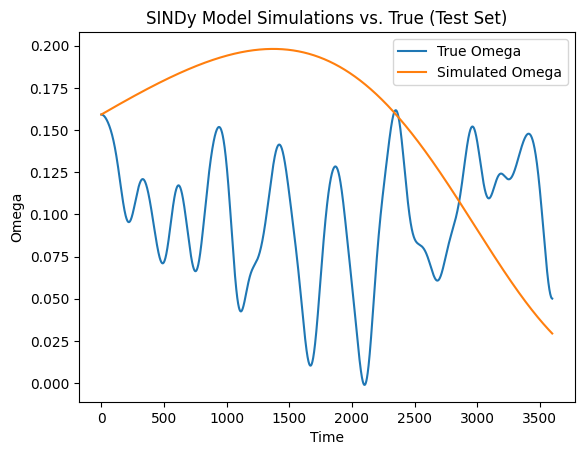

In [50]:
import matplotlib.pyplot as plt

# Get test data from one chunk
x_test_augmented_chunk = test_data_list[50]  # First test chunk
true_test = x_test_augmented_chunk[:, 1]  # True omega values

# Define initial conditions for the simulation
initial_conditions = x_test_augmented_chunk[0, :]

# Define time points for simulation
time_points = np.arange(len(true_test))

# Simulate the system using the SINDy model
simulated_data = sindy_models["exp_1000"][5].simulate(initial_conditions, time_points)

# Extract simulated omega values
simulated_omega = simulated_data[:, 1]

# Plot the results
plt.plot(true_test, label="True Omega")
plt.plot(simulated_omega, label="Simulated Omega")
plt.xlabel("Time")
plt.ylabel("Omega")
plt.title("SINDy Model Simulations vs. True (Test Set)")
plt.legend()
plt.show()



In [69]:
#sindy_models['exp_1000'][0].coefficients()
# get the mean coefficient of features
def get_mean_coefficients(sindy_models):
    mean_coefficients = {}
    for transform_name, models in sindy_models.items():
        mean_coefficients[transform_name] = np.mean([model.coefficients() for model in models], axis=0)
    return mean_coefficients



In [71]:
mean_coefficients = get_mean_coefficients(sindy_models)


feature_names = sindy_models['exp_1000'][0].get_feature_names()


for transform_name, coeff_matrix in mean_coefficients.items():
    print(f"Transform: {transform_name}")
      
    for eq_idx, coefficients in enumerate(coeff_matrix):
        print(f"  Equation {eq_idx + 1}:")
               
        for feature, coef in zip(feature_names, coefficients):
            print(f"    {feature}: {coef:.6e}") 


Transform: exp_1000
  Equation 1:
    1: 2.531413e-06
    theta: -9.259120e-08
    omega: 9.999207e-01
    time: 4.253807e-08
    theta^2: 7.148297e-10
    theta omega: 2.232606e-07
    theta time: -1.612538e-09
    omega^2: 1.617917e-04
    omega time: -5.168311e-06
    time^2: 2.354993e-08
    theta^3: 1.344602e-11
    theta^2 omega: -1.843642e-08
    theta^2 time: -5.828799e-11
    theta omega^2: 5.867185e-07
    theta omega time: 7.374280e-08
    theta time^2: 1.098082e-10
    omega^3: -9.048247e-04
    omega^2 time: 1.386052e-06
    omega time^2: -4.067124e-07
    time^3: -3.104675e-10
  Equation 2:
    1: -2.864220e-05
    theta: -5.113040e-05
    omega: -1.676107e-03
    time: 9.791005e-04
    theta^2: 1.031473e-07
    theta omega: 3.221363e-05
    theta time: -1.854835e-05
    omega^2: -1.999876e-03
    omega time: -6.111457e-04
    time^2: 3.812156e-05
    theta^3: -2.569559e-08
    theta^2 omega: -1.858267e-07
    theta^2 time: 7.766383e-08
    theta omega^2: -5.551334e-04
  

In [78]:
feature_names_list = list(feature_names)

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2',
 'theta^3',
 'theta^2 omega',
 'theta^2 time',
 'theta omega^2',
 'theta omega time',
 'theta time^2',
 'omega^3',
 'omega^2 time',
 'omega time^2',
 'time^3']

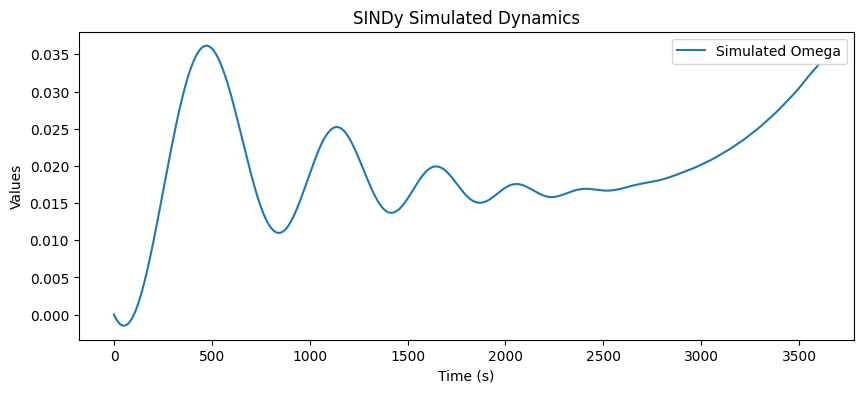

In [96]:
import numpy as np
from scipy.integrate import solve_ivp

def simulate_system(mean_coefficients, initial_conditions, t_span, feature_names):
   
    transform_name = "exp_1000"  # Choose transformation to simulate
    coeff_matrix = mean_coefficients[transform_name]

    def system_dynamics(t, state):
        theta, omega, time = state  # Extract variables
        derivatives = np.zeros_like(state)

        # Construct feature vector dynamically from feature_names
        feature_values = [1]  # Bias term (constant)
        for feature in feature_names:
            if feature == "theta":
                feature_values.append(theta)
            elif feature == "omega":
                feature_values.append(omega)
            elif feature == "time":
                feature_values.append(time)
            elif feature == "theta^2":
                feature_values.append(theta**2)
            elif feature == "omega^2":
                feature_values.append(omega**2)
            elif feature == "theta omega":
                feature_values.append(theta * omega)
            elif feature == "theta time":
                feature_values.append(theta * time)
            elif feature == "omega time":
                feature_values.append(omega * time)
            elif feature == "time^2":
                feature_values.append(time**2)
            elif feature == "theta^3":
                feature_values.append(theta**3)
            elif feature == "theta^2 omega":
                feature_values.append(theta**2 * omega)
            elif feature == "theta^2 time":
                feature_values.append(theta**2 * time)
            elif feature == "theta omega^2":
                feature_values.append(theta * omega**2)
            elif feature == "theta omega time":
                feature_values.append(theta * omega * time)
            elif feature == "theta time^2":
                feature_values.append(theta * time**2)
            elif feature == "omega^3":
                feature_values.append(omega**3)
            elif feature == "omega^2 time":
                feature_values.append(omega**2 * time)
            elif feature == "omega time^2":
                feature_values.append(omega * time**2)
            elif feature == "time^3":
                feature_values.append(time**3)

        feature_values = np.array(feature_values)  # Convert to NumPy array

        for eq_idx in range(len(state)):  # Iterate over theta_dot, omega_dot, and time_dot
            eq_coeffs = coeff_matrix[eq_idx]

            # Ensure feature_values and eq_coeffs have matching shapes
            if len(eq_coeffs) != len(feature_values):
                raise ValueError(
                    f"Mismatch: {len(eq_coeffs)} coefficients, but {len(feature_values)} features."
                )

            # Compute derivative using feature coefficients
            derivatives[eq_idx] = np.dot(eq_coeffs, feature_values)

        return derivatives

    # Solve ODE
    sol = solve_ivp(system_dynamics, (t_span[0], t_span[-1]), initial_conditions, t_eval=t_span)

    return sol.t, sol.y[0], sol.y[1], sol.y[2]  # Return time, theta, omega

# Extract feature names from SINDy
feature_names = sindy_models['exp_1000'][0].get_feature_names()


t_span = np.linspace(0, 3600*1, 1000)  # Simulate for one hour
initial_conditions = [0, 0, 0]  # Assume initial theta = 0, omega = 0, time = 0

sim_time, sim_theta, sim_omega, sim_t = simulate_system(mean_coefficients, initial_conditions, t_span, feature_names)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
#plt.plot(sim_time, sim_theta, label="Simulated Theta")
plt.plot(sim_time, sim_omega, label="Simulated Omega")
plt.xlabel("Time (s)")
plt.ylabel("Values")
plt.legend()
plt.title("SINDy Simulated Dynamics")
plt.show()

In [15]:
exp_1000 = scores['exp_1000']
#exp_3600 = scores['exp_3600']
linear_time = scores['linear_time']


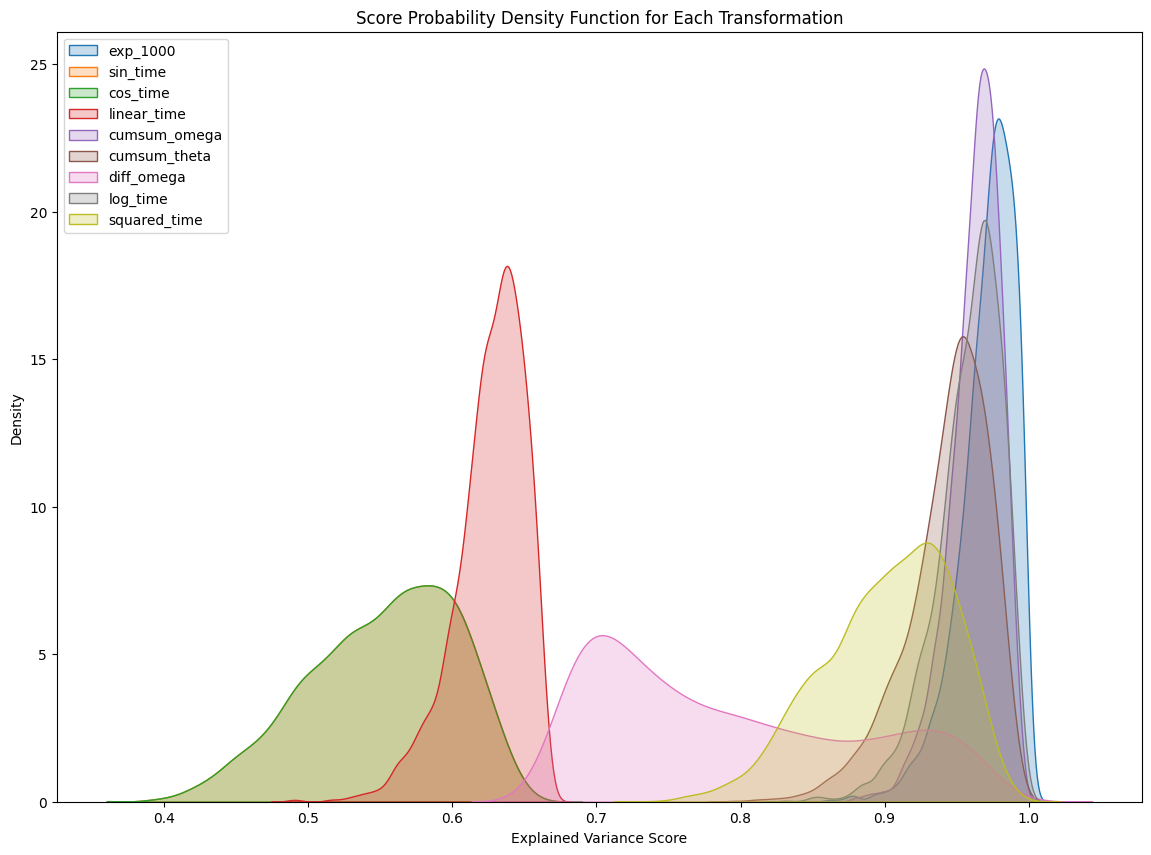

In [16]:
# plot the score with probability density function for each transformation 
plt.figure(figsize=(14, 10))

for key, score_list in scores.items():
    if key != 'diff_theta':
        sns.kdeplot(score_list, label=key, fill=True)

plt.xlabel('Explained Variance Score')
plt.ylabel('Density')
plt.title('Score Probability Density Function for Each Transformation')
plt.legend()
plt.show()





In [19]:
# find out the maximum score and lowest score for each transformation
max_score = {}
min_score = {}
for key in scores.keys():
    max_score[key] = max(scores[key])
    min_score[key] = min(scores[key])

print("Maximum Scores for each transformation:")
print(max_score)
print("\nMinimum Scores for each transformation:")
print(min_score)

# find out the chunk index of the maximum score and lowest score for each transformation
max_score_index = {}
min_score_index = {}
for key in scores.keys():
    max_score_index[key] = scores[key].index(max_score[key])
    min_score_index[key] = scores[key].index(min_score[key])

print("Chunk Index of Maximum Scores for each transformation:")
print(max_score_index)
print("\nChunk Index of Minimum Scores for each transformation:")
print(min_score_index)

# find out the chunk index of second maximum score for each transformation
second_max_score_index = {}
for key in scores.keys():
    scores_copy = scores[key].copy()
    scores_copy.remove(max_score[key])
    second_max_score_index[key] = scores_copy.index(max(scores_copy))
print("\nChunk Index of Second Maximum Scores for each transformation:")
print(second_max_score_index)








Maximum Scores for each transformation:
{'exp_1000': 0.9998833623363713, 'sin_time': 0.6579677324863401, 'cos_time': 0.65797092140727, 'linear_time': 0.6661647748199068, 'cumsum_omega': 0.9962197311999293, 'cumsum_theta': 0.9958047482220819, 'diff_omega': 0.9879164227839486, 'diff_theta': 0.9999950203733947, 'log_time': 0.9973746669826339, 'squared_time': 0.994577681767021}

Minimum Scores for each transformation:
{'exp_1000': 0.8606937082516821, 'sin_time': 0.3917963766960122, 'cos_time': 0.39179669166943926, 'linear_time': 0.48928732206402054, 'cumsum_omega': 0.8788205016883134, 'cumsum_theta': 0.7953240751180823, 'diff_omega': 0.6696898771546032, 'diff_theta': 0.9673532170583106, 'log_time': 0.831434015297622, 'squared_time': 0.7398807451420072}
Chunk Index of Maximum Scores for each transformation:
{'exp_1000': 1789, 'sin_time': 1789, 'cos_time': 1789, 'linear_time': 703, 'cumsum_omega': 1129, 'cumsum_theta': 1789, 'diff_omega': 1004, 'diff_theta': 1713, 'log_time': 703, 'squared_t

In [29]:
low_scores = {
    "linear_time": [score for score in linear_time_score if score < 0.4],
    "cumsum_omega": [score for score in cumsum_omega_score if score < 0.7],
    "cumsum_theta": [score for score in cumsum_theta_score if score < 0.7],
    "log_time": [score for score in log_time_score if score < 0.7],
    "squared_time": [score for score in squared_time_score if score < 0.7],
    "exp_time": [score for score in exp_time_score if score < 0.8],
}

# Print only the transformations for all scores
for key, values in low_scores.items():
    if values:
        print(f"{key}: {values}") # Print only the transformations that have low scores
        print(f"Number of low scores for {key}: {len(values)}") # Print the number of low scores in each transformation
        print(f"Lowest score for {key}: {min(values)}", f"Highest score: {max(values)}") # Find the  lowwest score in each transformation
        #print(f"Highest score for {key}: {max(values)}") # find the  highest score in each transformation
        print()


linear_time: [0.3849114324353538, 0.3967287431460244, 0.383566320393546, 0.39831782369743546, 0.39524815836038957, 0.39632920531948296, 0.39489566732396614, 0.3870912029674954, 0.3773605501140833, 0.3994486627451989, 0.39223403246431193, 0.39697542509943656, 0.37519606400561134, 0.39871837655337955, 0.39723795652407157, 0.3791647766087393, 0.39968382673830627, 0.37586439314589787, 0.39533314978946876, 0.3911816173123522, 0.39804750888992996, 0.3852632380256238, 0.38490482665536346, 0.39183769260617024, 0.3851884978282105, 0.39985163006337593, 0.39089462307892475, 0.3899926073779561, 0.39484120465991585, 0.3916718979359273, 0.39995078463271505, 0.39563174489289404, 0.38975525216428664, 0.3873929962818507, 0.39075526077110806, 0.39317768411795395, 0.39343045856400777, 0.3991584809151036, 0.3945096350573392, 0.3865775167217369, 0.39842789182261207]
Number of low scores for linear_time: 41
Lowest score for linear_time: 0.37519606400561134 Highest score: 0.39995078463271505

cumsum_omega: [

In [21]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [ ]:
sindy_models['diff_omega']

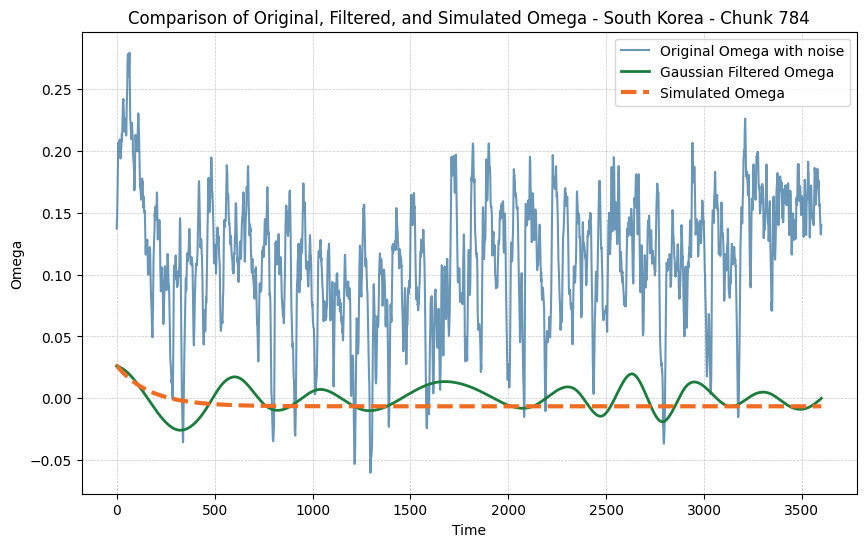

In [31]:
filtered_data = chunks
n = 783
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 17)
simulate_sindy_model(sindy_models['diff_theta'][n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [72]:
# Split training and testing data
def split_data(data, train_size=0.8):
    train_data = data[:int(len(data)*train_size)]
    test_data = data[int(len(data)*train_size):]
    return train_data, test_data

# Split the data into training and testing data
train_data, test_data = split_data(filtered_data)

# train the model on the training data
sindy_models, scores = calculate_model_scores(train_data, 'South Korea', n=3)

mean_coefficients = get_mean_coefficients(sindy_models)


feature_names = sindy_models['exp_1000'][0].get_feature_names()


for transform_name, coeff_matrix in mean_coefficients.items():
    print(f"Transform: {transform_name}")
      
    for eq_idx, coefficients in enumerate(coeff_matrix):
        print(f"  Equation {eq_idx + 1}:")
               
        for feature, coef in zip(feature_names, coefficients):
            print(f"    {feature}: {coef:.6e}") 




Mean Model Score for South Korea using exp_1000: 0.9019589962727081
Transform: exp_1000
  Equation 1:
    1: 2.912218e-06
    theta: -9.535957e-08
    omega: 9.999140e-01
    time: 2.201567e-07
    theta^2: 8.386809e-10
    theta omega: 2.445900e-07
    theta time: -3.451279e-09
    omega^2: 1.898240e-04
    omega time: -5.291623e-06
    time^2: 2.407393e-08
    theta^3: 1.436632e-11
    theta^2 omega: -1.843424e-08
    theta^2 time: -6.820359e-11
    theta omega^2: 6.277210e-07
    theta omega time: 7.407162e-08
    theta time^2: 1.920096e-10
    omega^3: -9.397423e-04
    omega^2 time: 1.468451e-06
    omega time^2: -4.055989e-07
    time^3: -7.310635e-10
  Equation 2:
    1: -5.910973e-05
    theta: -5.352708e-05
    omega: -2.227332e-03
    time: 1.027262e-03
    theta^2: 1.230322e-07
    theta omega: 3.516903e-05
    theta time: -1.854272e-05
    omega^2: -1.294029e-03
    omega time: -5.607627e-04
    time^2: 3.642887e-05
    theta^3: -2.727951e-08
    theta^2 omega: -3.313362e-0

In [ ]:
# use the mean coefficients to simulate the model
 

In [ ]:
# Define the number of time points for simulation
total_time = len(train_data[0]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Define the initial conditions for the simulation
initial_conditions = [integrate_data(train_data[0]['omega_filtered'].values)[0], 
                      train_data[0]['omega_filtered'].iloc[0], 0]

# Simulate and plot results for the first chunk
simulate_sindy_model(sindy_models['exp_1000'][0], initial_conditions, time_points, 'South Korea - Training Data Chunk 1', train_data[0]['omega'].values, train_data[0]['omega_filtered'].values)


In [67]:
# Combine all training data into a single DataFrame
combined_train_data = pd.concat(train_data)

# Integrate the omega data to get theta
combined_train_data['theta'] = integrate_data(combined_train_data['omega_filtered'].values, dt=1)

# Prepare the data for SINDy model
stacked_data = np.column_stack((combined_train_data['theta'].values, combined_train_data['omega_filtered'].values))

# Apply the selected time transformation
t_train = (np.exp((combined_train_data.index - combined_train_data.index[0]).total_seconds().to_numpy() / 3600) - 1).reshape(-1, 1)

# Augment the data with the time transformation
x_train_augmented = np.hstack([stacked_data, t_train])

# Define feature names and create the SINDy model
feature_names = ["theta", "omega", "time"]
polynomial_library = ps.PolynomialLibrary(degree=3)
sparse_regression_optimizer = ps.STLSQ(threshold=1e-10)

model = ps.SINDy(feature_names=feature_names, 
                 feature_library=polynomial_library,
                 optimizer=sparse_regression_optimizer)

# Fit the SINDy model
model.fit(x_train_augmented, t=1)

# Define the number of time points for simulation
total_time = len(combined_train_data)
time_points = np.arange(0, total_time, 1)

# Define the initial conditions for the simulation
initial_conditions = [combined_train_data['theta'].values[0], 
                      combined_train_data['omega_filtered'].iloc[0], 0]

# Simulate and plot results for the combined training data
simulate_sindy_model(model, initial_conditions, time_points, 'South Korea - Combined Training Data', combined_train_data['omega'].values, combined_train_data['omega_filtered'].values)




C:\Users\wp7528\AppData\Local\Temp\ipykernel_11928\2860045936.py:11: RuntimeWarning: overflow encountered in exp
  t_train = (np.exp((combined_train_data.index - combined_train_data.index[0]).total_seconds().to_numpy() / 3600) - 1).reshape(-1, 1)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [24]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    region_colors = {'South Korea': '#1b9e77'}

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "", color=region_colors[region_name])

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Feature Candidates", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for South Korea", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    return ax  # Return the ax object

<Axes: title={'center': 'Coefficients with Error Bars for South Korea'}, xlabel='Feature Candidates', ylabel='Coefficient Value'>

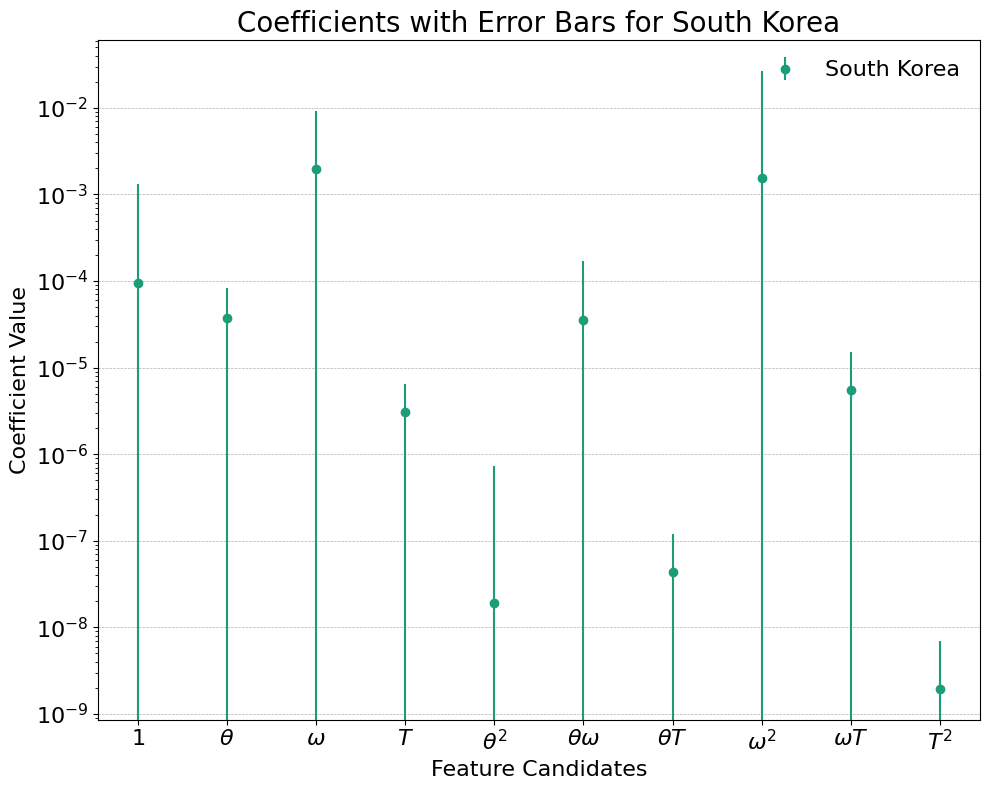

In [26]:
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$T$', 
                r'$\theta^2$', r'$\theta\omega$', r'$\theta T$', r'$\omega^2$', 
                r'$\omega T$',r'$T^2$']
#apply plot_coefficients_for_regions function for South Korea
plot_coefficients_for_regions({'South Korea': {'means': skmean, 'stds': skstd}}, feature_names)